# This is the Jupyter Notebook for the Iterative Data Cleaning Process

In [1]:
!unzip /content/Cropped_Data_4000_Three.zip -d /content/

Archive:  /content/Cropped_Data_4000_Three.zip
   creating: /content/Cropped_Data_4000_Three/Algae/
  inflating: /content/Cropped_Data_4000_Three/Algae/420041461011010173.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/420041461011091120.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/420041461011243323.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/420041461011253896.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/420041461011399166.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/4200414610114801502.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/4200414610116111778.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/4200414610116611504.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/42004146101311474.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/42004146101399487.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/420041461017301695.jpg  
  inflating: /content/Cropped_Data_4000_Three/Algae/

In [2]:
#Import Statements
import numpy as np
import math
import matplotlib.pyplot as plt
import torchvision
import torch
from torchvision import datasets, transforms
from torch.utils.data import random_split
import torch.nn as nn
import torchvision.models as models
from tqdm import tqdm
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
!pip install timm
import timm
import os
import csv
import shutil
import random

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 11.1 MB/s eta 0:00:00


In [3]:
#This is one big cell of all the helper functions we need

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y
    def __len__(self):
        return len(self.subset)
def prepare_and_get_loaders(validation_split, batch_size, num_workers, dir_path):
    """
    This function loads and partitions our image data.

    val_split: proportion of the data that will be in the validation split
    batch_size: size of batches
    num_workers: number of parallel processors
    dir_path: directory path of the data
    """

    #Transforms to apply to training and test data
    data_transforms = {
        'train': transforms.Compose([
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]),

        'test': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    }
    full_dataset = datasets.ImageFolder(dir_path)

    m = len(full_dataset)
    val_size = int(validation_split * m)
    train_size = m - val_size

    train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])
    train_dataset = MyDataset(train_dataset, transform=data_transforms['train'])
    val_dataset = MyDataset(val_dataset, transform=data_transforms['test'])

    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

    return train_loader, val_loader

def finetune(model, train_loader, val_loader, learning_rate, num_epochs, L2, momentum1, momentum2, stepsize, gamma):
    """

    Finetunes the given model on the loader data, and returns the trained model as well as the losses
    and final validation accuracy for plotting.

    model: the Pytorch model
    train_loader: the loader for the training data
    val_loader: the loader for the validation data
    learning_rate: alpha, the learning rate
    num_epochs: the number of epochs to train for
    L2: the L2 regularization value
    momentum1: the first momentum value
    momentum2: the second momentum value
    stepsize: the number of epochs between lowering the learning rate
    gamma: the ratio to multiply the learning rate at each step size

    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"My Device is {device}")
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()

    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=L2, betas = (momentum1, momentum2))

    scheduler = StepLR(optimizer, step_size=stepsize, gamma=gamma)

    hist = {'train': [], 'val': []} # History of training and validation losses

    for epoch in tqdm(range(num_epochs), desc = "Training Epoch: "):
        model.train() #Training mode
        total_loss = 0.0
        for inputs, labels in train_loader:
            #put stuff on device
            inputs = inputs.to(device)
            labels = labels.to(device)

            #zero optimizer
            optimizer.zero_grad()

            #get outputs + train
            outputs = model(inputs)

            #get loss and do backward
            loss = criterion(outputs, labels)
            loss.backward()

            #step
            optimizer.step()

            total_loss += loss.item()

            # Free memory
            if device == "cuda":
              del inputs, labels, outputs, loss

        avg_train_loss = total_loss / len(train_loader)
        hist['train'].append(avg_train_loss)

        #Validation Mode Now
        model.eval()
        total_loss = 0.0

        #keep track of correct labels so we can get the val accuracy
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                #put on device
                inputs = inputs.to(device)
                labels = labels.to(device)

                #get outputs
                outputs = model(inputs)

                #get loss
                loss = criterion(outputs, labels)
                total_loss += loss.item()

                #https://www.digitalocean.com/community/tutorials/pytorch-torch-max
                max_element, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Free memory
                if device == "cuda":
                  del inputs, labels, outputs, loss

        avg_val_loss = total_loss / len(val_loader)
        hist['val'].append(avg_val_loss)
        val_accuracy = 100 * correct / total
        print(f'Epoch [{epoch+1}/{num_epochs}], Training Loss: {avg_train_loss:.4f}, Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
        scheduler.step()

        if device == "cuda":
          torch.cuda.empty_cache() #cuda memory was filling up
    #final val accuracy
    final_val_accuracy = 100*correct/total

    return model, hist, final_val_accuracy

def load_model(arch, dropout, num_classes):
    """

    Loads a pretrained model, but with the final output layer removed and replaced with a randomly
    initialized output layer that will classify among the coral.

    """

    #select the model we want
    if arch == "resnet18":
        model = models.resnet18(weights="ResNet18_Weights.DEFAULT")
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "resnet34":
        model = models.resnet34(weights="DEFAULT")
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "mobile":
        model = models.mobilenet_v2(weights="MobileNet_V2_Weights.DEFAULT")
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "alexnet":
            model = models.alexnet(weights="AlexNet_Weights.DEFAULT")
            num_ftrs = model.classifier[1].in_features
            model.classifier[6] = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "vgg16":
        model = models.vgg16(weights="VGG16_Weights.DEFAULT")
        num_ftrs = model.classifier[0].in_features
        model.classifier[6] = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "densenet":
        model = models.densenet121(weights="DenseNet121_Weights.DEFAULT")
        num_ftrs = model.classifier.in_features
        model.classifier = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "inception":
        model = models.inception_v3(weights="Inception_V3_Weights.DEFAULT")
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "efficientnet":
        model = models.efficientnet_b0(weights="EfficientNet_B0_Weights.DEFAULT")
        num_ftrs = model.classifier[1].in_features
        model.classifier = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "googlenet":
        model = models.googlenet(weights="GoogLeNet_Weights.DEFAULT")
        num_ftrs = model.fc.in_features
        model.fc = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "squeezenet":
        model = models.squeezenet1_0(weights="SqueezeNet1_0_Weights.DEFAULT")
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes

    elif arch == "vit":
        model = timm.create_model('vit_base_patch16_224', pretrained=True)
        num_ftrs = model.head.in_features
        model.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))
    elif arch == "deit":
        model = timm.create_model('deit_base_patch16_224', pretrained=True)
        num_ftrs = model.head.in_features
        model.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "mixer":
        model = timm.create_model('mixer_b16_224', pretrained=True)
        num_ftrs = model.head.in_features
        model.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))

    elif arch == "tnt":
        model = timm.create_model('tnt_s_patch16_224', pretrained=True)
        num_ftrs = model.head.in_features
        model.head = nn.Sequential(nn.Dropout(dropout), nn.Linear(num_ftrs, num_classes))
    else:
        print("Incorrect model Architecture selected")
        raise

    return model


def plot_history(hist):
    epochs = range(1, len(hist['train']) + 1)

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, hist['train'], 'b', label='Training loss')
    plt.plot(epochs, hist['val'], 'r', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()


def plot_label_history(label_accuracy_history, validation_accuracies):
    epochs = range(0, len(label_accuracy_history))

    # Plot training and validation loss
    plt.figure(figsize=(12, 6))
    plt.plot(epochs, label_accuracy_history, 'b', label = "Label Accuracies")
    plt.plot(epochs, validation_accuracies, 'r', label = "Val Accuracies")
    plt.title('Accuracies vs. Iteration')
    plt.xlabel('Iteration')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()


def create_labels_csv(data_dir, csv_filename):
    """
    Create a CSV file of the label, name, and also the path of the images in a particular directory
    without editing the images.

    data_dir: Directory containing the images organized by label.
    csv_filename: Path to the CSV file to be created. Can also overwrite
    """

    with open(csv_filename, mode='w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)
        csv_writer.writerow(['image_path', 'image_name', 'label'])

        for label in os.listdir(data_dir):
            label_dir = os.path.join(data_dir, label)
            if os.path.isdir(label_dir):
                for image_file in os.listdir(label_dir):
                    image_path = os.path.join(label_dir, image_file)
                    image_name = os.path.basename(image_path)
                    csv_writer.writerow([image_path, image_name, label])

    print(f"CSV file created at {csv_filename}")

def create_dirty_data(original_dir, dirty_dir, x):
    """
    Create a dataset with x% of the data having randomized labels,
    while the rest retain their original labels.

    original_dir: The directory of the original dataset.
    dirty_dir: The directory to store the dirty dataset.
    x: The proportion of the dataset to be made 'dirty' (0 < x < 1).
    """

    print("Deleting Dirty Data Directory")
    if os.path.exists(dirty_dir):
        shutil.rmtree(dirty_dir)
    print("Writing Dirty Data Directory")
    # Create the dirty directory
    os.makedirs(dirty_dir)

    # Get all image paths and their labels
    images = []
    for class_name in os.listdir(original_dir):
        class_dir = os.path.join(original_dir, class_name)
        if os.path.isdir(class_dir):
            images.extend([(os.path.join(class_dir, img), class_name) for img in os.listdir(class_dir)])

    # Randomly select a subset of images to be 'dirty'
    num_dirty = int(len(images) * x)
    dirty_data = set(random.sample(images, num_dirty))

    # Copy images to the new directory
    class_names = os.listdir(original_dir)

    for img_path, label in tqdm(images, desc="Writing Data"):
        if (img_path, label) in dirty_data:
            # Randomize label for dirty data
            new_label = random.choice(class_names)
        else:
            new_label = label

        new_path = os.path.join(dirty_dir, new_label, os.path.basename(img_path))
        os.makedirs(os.path.dirname(new_path), exist_ok=True)
        shutil.copy(img_path, new_path)


def calculate_label_accuracy(clean_csv, dirty_csv):
    """
    Calculate the label accuracy of the dirty dataset compared to the clean dataset.

    clean_csv: Path to the CSV file with the original (clean) labels.
    dirty_csv: Path to the CSV file with the dirty labels.
    """

    # Read the CSV files and store labels in dictionaries
    clean_labels = {}
    dirty_labels = {}

    with open(clean_csv, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            clean_labels[row['image_name']] = row['label']

    with open(dirty_csv, mode='r') as file:
        reader = csv.DictReader(file)
        for row in reader:
            dirty_labels[row['image_name']] = row['label']

    # Compare labels and calculate accuracy
    correct = 0
    total = len(dirty_labels)

    for image_name, label in dirty_labels.items():
        if image_name not in clean_labels:
            print("Image not found!")
        if clean_labels[image_name] == label:
            correct += 1

    accuracy = correct / total if total > 0 else 0
    return accuracy



class CleaningDataset(torch.utils.data.Dataset): #new dataset that also returns the path to the image
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform
    def __getitem__(self, index):
        x, y = self.subset[index]
        img_path = self.subset.imgs[index][0]
        if self.transform:
            x = self.transform(x)
        return x, y, img_path
    def __len__(self):
        return len(self.subset)



def cleaning_loader(dir_path):
    """
    This function makes our cleaning data loader, and we also need the class names for manual relabelling

    dir_path: directory path of the data
    """

    #Loading transform
    data_transforms = {
        'load': transforms.Compose([
            transforms.Resize((224,224)),
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
        ])
    }
    full_dataset = datasets.ImageFolder(dir_path)
    class_names = full_dataset.classes

    load_dataset = CleaningDataset(full_dataset, transform=data_transforms['load'])
    clean_loader = torch.utils.data.DataLoader(load_dataset, shuffle=False, num_workers=0)

    return clean_loader, class_names




def get_misclassified_images(loader, model, class_names, confidence_threshold):
    model.eval()
    misclassified = []

    with torch.no_grad():
        for images, true_labels, paths in tqdm(iter(loader), desc="Evaluating"):
            images = images.to('cuda')
            outputs = model(images)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            max_probs, predicted_labels = torch.max(probabilities, dim=1)

            for i in range(len(images)):
                if predicted_labels[i] != true_labels[i] and max_probs[i] > confidence_threshold:
                    misclassified.append({
                        'image': images[i],
                        'true_label': true_labels[i],
                        'predicted_label': predicted_labels[i],
                        'confidence': max_probs[i].item(),
                        'path': paths[i]
                    })

    # Sort in descending order cuz we wanna show the worst classified first
    misclassified.sort(key=lambda x: x['confidence'], reverse=True)
    return misclassified



def rewrite_data_with_new_labels(dir_1, dir_2, misclassified_images):
    """
    Copy data from dir_1 to dir_2, changing the labels of misclassified images.

    dir_1: Current directory of the data.
    dir_2: Target directory where data will be rewritten.
    misclassified_images: List of misclassified images and their new labels. Gotten from the function above.
    """

    # Create dir_2 if it doesn't exist
    if not os.path.exists(dir_2):
        os.makedirs(dir_2)

    # Create a set of misclassified image paths for quick lookup
    misclassified_paths = set([item['path'] for item in misclassified_images])

    # Mapping of predicted labels for misclassified images
    predicted_labels = {item['path']: class_names[item['predicted_label'].item()] for item in misclassified_images}


    # Iterate over dir_1 and copy files to dir_2
    for root, dirs, files in os.walk(dir_1):
        for file in tqdm(files, desc="Copying data"):
            src_path = os.path.join(root, file)

            # Determine the target directory based on whether the image is misclassified
            if src_path in misclassified_paths:
                # Use the new predicted label directory for misclassified images
                new_label_dir = os.path.join(dir_2, predicted_labels[src_path])
            else:
                # Use the same directory structure as dir_1 for correctly classified images
                rel_path = os.path.relpath(root, dir_1)
                new_label_dir = os.path.join(dir_2, rel_path)

            # Create target directory if it doesn't exist
            os.makedirs(new_label_dir, exist_ok=True)

            # Copy file to the new directory
            shutil.copy(src_path, os.path.join(new_label_dir, file))





# Below, we perform the automatic data cleaning process

In [4]:
#Parameters we actually care about and should change:
dirty_proportion = 0  # Define the starting dirty proportion of the dataset we will be using
confidence_threshold = 0.7 #If we are confident that the image is the other label, change the label
num_iterations = 10


#Define the clean, first dirty, and second dirty directories.
clean_dir = "Cropped_Data_4000_Three"
dirty_dir_1 = "Dirty Data 1"
dirty_dir_2 =  "Dirty Data 2"

#Define the CSVs for each one
clean_csv = "Clean_Labels.csv"
dirty_csv = "Dirty_Labels.csv"


# Initialize our datasets and csvs before going into the loop
create_labels_csv(clean_dir, clean_csv)
create_dirty_data(clean_dir, dirty_dir_1, dirty_proportion)
create_labels_csv(dirty_dir_1, dirty_csv)

# Double check our dirty accuracy - should be close to: 1 - 2/3*dirty_proportion
print(f"Our dirty proportion should be approximately: {1-2/3*dirty_proportion}")
label_accuracy = calculate_label_accuracy(clean_csv, dirty_csv)
print(f"Label accuracy of the dirty dataset: {label_accuracy}")


#Initialize what our current dirty dataset is for the iterative loop, and other starting variables
current_dirty_dataset = 1
label_accuracy_history = []
validation_accuracies = []

#Training params
arch = "deit" #(Model architecture we'll use) - best one is deit
validation_split = 0.2
batch_size = 64
num_workers = 2

dropout = 0
num_classes = 3

learning_rate = 0.0001
num_epochs = 4
L2 = 10**(-6)
momentum1 = 0.8
momentum2 = 0.9
stepsize = 3
gamma = 0.1

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")


CSV file created at Clean_Labels.csv
Deleting Dirty Data Directory
Writing Dirty Data Directory


Writing Data: 100%|██████████| 3860/3860 [00:00<00:00, 9716.71it/s]


CSV file created at Dirty_Labels.csv
Our dirty proportion should be approximately: 1.0
Label accuracy of the dirty dataset: 1.0
Device is cuda


## We perform the data cleaning process below.
### It occurs in the following process:

1. Train a model on the current dirty dataset

2. Evaluate that model on the current dirty dataset. If the model is over the confidence threshold on an image, change the label and write the new dataset to the other dirty dataset. Log the new dataset's label accuracy. The other dirty dataset is the new current dataset.

3. Repreat steps 1-2 for the desired number of iterations.

In [ ]:
for it in range(num_iterations):
    #Step 1: Train a model on the current dirty dataset
    if current_dirty_dataset == 1:
        dir_path = dirty_dir_1
        new_dir_path = dirty_dir_2
    elif current_dirty_dataset == 2:
        dir_path = dirty_dir_2
        new_dir_path = dirty_dir_1
    else:
        raise

    print(f"Our Current Dataset is {dir_path}")
    #Track the progress of the label accuracy
    create_labels_csv(dir_path, dirty_csv)
    label_accuracy = calculate_label_accuracy(clean_csv, dirty_csv)
    print(f"New label accuracy is {label_accuracy}")
    label_accuracy_history.append(label_accuracy)

    #Make our dataset w/ the dirty data
    train_loader, val_loader = prepare_and_get_loaders(validation_split, batch_size, num_workers, dir_path)

    #Make our model with the best one we found
    model = load_model(arch, dropout, num_classes)

    #Train the model
    model, hist, final_val_accuracy = finetune(model,
                                          train_loader,
                                          val_loader,
                                          learning_rate,
                                          num_epochs,
                                          L2,
                                          momentum1,
                                          momentum2,
                                          stepsize,
                                          gamma)
    validation_accuracies.append(final_val_accuracy)


    #Step 2: Evaluate the model on the dataset and keep track of the ones above the confidence threshold.
    #Then, write the data to the new directory with the only change being that the images the model wants to relabel are
    #relabelled
    clean_loader, class_names = cleaning_loader(dir_path)
    misclassified_images = get_misclassified_images(clean_loader, model, class_names, confidence_threshold)
    print(f"We are going to relabel {len(misclassified_images)} images")

    #cuda cleaning
    if device == "cuda":
        del model
        torch.cuda.empty_cache() #cuda memory was filling up


    #write the data to new directories, and switch the current dirty dataset
    rewrite_data_with_new_labels(dir_path, new_dir_path, misclassified_images)
    if current_dirty_dataset == 1:
        current_dirty_dataset = 2
    elif current_dirty_dataset == 2:
        current_dirty_dataset = 1
    else:
      raise

    #Accuracy will be logged at new loop - loop until iterations are complete






Our Current Dataset is Dirty Data 1
CSV file created at Dirty_Labels.csv
New label accuracy is 1.0


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

My Device is cuda


Training Epoch:  25%|██▌       | 1/4 [01:51<05:33, 111.18s/it]

Epoch [1/4], Training Loss: 0.6331, Validation Loss: 0.4249, Validation Accuracy: 81.87%


Training Epoch:  50%|█████     | 2/4 [03:40<03:40, 110.03s/it]

Epoch [2/4], Training Loss: 0.3411, Validation Loss: 0.4216, Validation Accuracy: 86.01%


Training Epoch:  75%|███████▌  | 3/4 [05:32<01:51, 111.11s/it]

Epoch [3/4], Training Loss: 0.1580, Validation Loss: 0.4115, Validation Accuracy: 86.79%


Training Epoch: 100%|██████████| 4/4 [07:25<00:00, 111.41s/it]


Epoch [4/4], Training Loss: 0.0335, Validation Loss: 0.4361, Validation Accuracy: 88.47%


Evaluating: 100%|██████████| 3860/3860 [01:03<00:00, 60.74it/s]


We are going to relabel 72 images


Copying data: 0it [00:00, ?it/s]
Copying data: 100%|██████████| 1153/1153 [00:00<00:00, 1875.83it/s]


Our Current Dataset is Dirty Data 2
CSV file created at Dirty_Labels.csv
New label accuracy is 0.9813471502590674
My Device is cuda


Training Epoch:  25%|██▌       | 1/4 [01:52<05:37, 112.51s/it]

Epoch [1/4], Training Loss: 0.5778, Validation Loss: 0.4932, Validation Accuracy: 78.11%


Training Epoch:  50%|█████     | 2/4 [03:45<03:45, 112.79s/it]

Epoch [2/4], Training Loss: 0.3042, Validation Loss: 0.3470, Validation Accuracy: 87.95%


Training Epoch:  75%|███████▌  | 3/4 [05:38<01:53, 113.05s/it]

Epoch [3/4], Training Loss: 0.1370, Validation Loss: 0.3275, Validation Accuracy: 88.08%


Training Epoch: 100%|██████████| 4/4 [07:32<00:00, 113.15s/it]


Epoch [4/4], Training Loss: 0.0311, Validation Loss: 0.3362, Validation Accuracy: 89.38%


Evaluating: 100%|██████████| 3860/3860 [01:03<00:00, 60.32it/s]


We are going to relabel 59 images


Copying data: 0it [00:00, ?it/s]
Copying data: 100%|██████████| 1117/1117 [00:00<00:00, 4595.19it/s]


Our Current Dataset is Dirty Data 1
CSV file created at Dirty_Labels.csv
New label accuracy is 0.9875647668393782
My Device is cuda


Training Epoch:  25%|██▌       | 1/4 [01:58<05:54, 118.21s/it]

Epoch [1/4], Training Loss: 0.6364, Validation Loss: 0.5240, Validation Accuracy: 80.58%


Training Epoch:  50%|█████     | 2/4 [03:56<03:56, 118.26s/it]

Epoch [2/4], Training Loss: 0.3877, Validation Loss: 0.4242, Validation Accuracy: 82.71%


Training Epoch:  75%|███████▌  | 3/4 [05:54<01:58, 118.18s/it]

Epoch [3/4], Training Loss: 0.2376, Validation Loss: 0.4494, Validation Accuracy: 81.95%


Training Epoch: 100%|██████████| 4/4 [07:52<00:00, 118.14s/it]


Epoch [4/4], Training Loss: 0.1158, Validation Loss: 0.4884, Validation Accuracy: 84.59%


Evaluating: 100%|██████████| 3991/3991 [01:06<00:00, 60.32it/s]


We are going to relabel 138 images


Copying data: 0it [00:00, ?it/s]
Copying data: 100%|██████████| 1180/1180 [00:00<00:00, 5326.99it/s]


Our Current Dataset is Dirty Data 2
CSV file created at Dirty_Labels.csv
New label accuracy is 0.9761658031088083
My Device is cuda


Training Epoch:  25%|██▌       | 1/4 [01:58<05:55, 118.44s/it]

Epoch [1/4], Training Loss: 0.6148, Validation Loss: 0.4497, Validation Accuracy: 81.67%


Training Epoch:  50%|█████     | 2/4 [03:57<03:57, 118.56s/it]

Epoch [2/4], Training Loss: 0.3794, Validation Loss: 0.4822, Validation Accuracy: 82.29%


Training Epoch:  75%|███████▌  | 3/4 [05:55<01:58, 118.28s/it]

Epoch [3/4], Training Loss: 0.2279, Validation Loss: 0.4829, Validation Accuracy: 81.80%


Training Epoch: 100%|██████████| 4/4 [07:52<00:00, 118.13s/it]


Epoch [4/4], Training Loss: 0.1169, Validation Loss: 0.5091, Validation Accuracy: 84.66%


Evaluating: 100%|██████████| 4013/4013 [01:06<00:00, 60.50it/s]


We are going to relabel 141 images


Copying data: 0it [00:00, ?it/s]
Copying data: 100%|██████████| 1186/1186 [00:00<00:00, 5298.78it/s]


Our Current Dataset is Dirty Data 1
CSV file created at Dirty_Labels.csv
New label accuracy is 0.9805699481865285
My Device is cuda


Training Epoch:  25%|██▌       | 1/4 [01:59<05:57, 119.08s/it]

Epoch [1/4], Training Loss: 0.6428, Validation Loss: 0.5211, Validation Accuracy: 77.98%


Training Epoch:  50%|█████     | 2/4 [03:58<03:58, 119.49s/it]

Epoch [2/4], Training Loss: 0.3946, Validation Loss: 0.5038, Validation Accuracy: 79.95%


Training Epoch:  75%|███████▌  | 3/4 [05:58<01:59, 119.54s/it]

Epoch [3/4], Training Loss: 0.2628, Validation Loss: 0.4764, Validation Accuracy: 81.80%


Training Epoch: 100%|██████████| 4/4 [07:57<00:00, 119.44s/it]


Epoch [4/4], Training Loss: 0.1381, Validation Loss: 0.5624, Validation Accuracy: 83.27%


Evaluating: 100%|██████████| 4068/4068 [01:07<00:00, 60.68it/s]


We are going to relabel 162 images


Copying data: 0it [00:00, ?it/s]
Copying data: 100%|██████████| 1198/1198 [00:00<00:00, 4236.91it/s]


Our Current Dataset is Dirty Data 2
CSV file created at Dirty_Labels.csv
New label accuracy is 0.9689119170984456
My Device is cuda


Training Epoch:  25%|██▌       | 1/4 [02:00<06:00, 120.24s/it]

Epoch [1/4], Training Loss: 0.6250, Validation Loss: 0.5665, Validation Accuracy: 77.52%


Training Epoch:  50%|█████     | 2/4 [04:00<04:00, 120.33s/it]

Epoch [2/4], Training Loss: 0.3809, Validation Loss: 0.4710, Validation Accuracy: 81.53%


Training Epoch:  75%|███████▌  | 3/4 [06:02<02:00, 120.83s/it]

Epoch [3/4], Training Loss: 0.2768, Validation Loss: 0.4709, Validation Accuracy: 83.11%


Training Epoch: 100%|██████████| 4/4 [08:02<00:00, 120.71s/it]


Epoch [4/4], Training Loss: 0.1448, Validation Loss: 0.5374, Validation Accuracy: 81.90%


Evaluating: 100%|██████████| 4116/4116 [01:08<00:00, 60.24it/s]


We are going to relabel 161 images


Copying data: 0it [00:00, ?it/s]
Copying data: 100%|██████████| 1219/1219 [00:00<00:00, 4774.38it/s]


Our Current Dataset is Dirty Data 1
CSV file created at Dirty_Labels.csv
New label accuracy is 0.9681347150259068
My Device is cuda


Training Epoch:  25%|██▌       | 1/4 [02:03<06:10, 123.55s/it]

Epoch [1/4], Training Loss: 0.6541, Validation Loss: 0.5065, Validation Accuracy: 79.25%


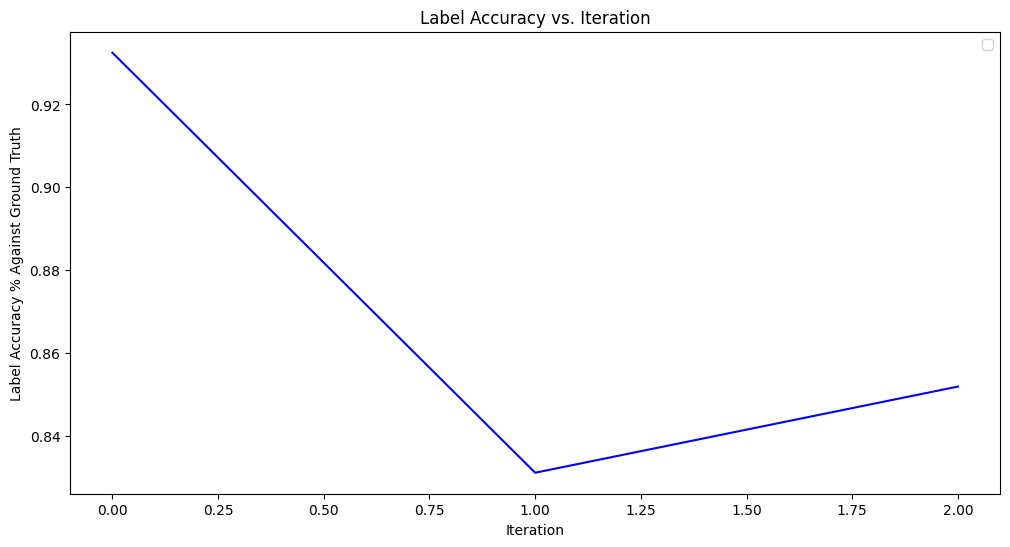

In [30]:
plot_label_history(label_accuracy_history, validation_accuracies)

# junk below

In [ ]:
clean_dir = r"C:\Users\Brandon\Desktop\Classes\E208\Homework\E208_Final\Automatic Data Cleaning\Cropped_Data_400"
create_labels_csv(clean_dir, 'Clean_Labels.csv')

dirty_dir = r"C:\Users\Brandon\Desktop\Classes\E208\Homework\E208_Final\Automatic Data Cleaning\Dirty Data"
x = 0.5
create_dirty_data(clean_dir, dirty_dir, x)
create_labels_csv(dirty_dir, "Dirty_Labels.csv")


label_accuracy = calculate_label_accuracy("Clean_Labels.csv", "Dirty_Labels.csv")
print(f"Label accuracy of the dirty dataset: {label_accuracy}")


CSV file created at Clean_Labels.csv
Deleting Dirty Data Directory
Writing Dirty Data Directory


Writing Data: 100%|█████████████████████████████████████████████████████████████████| 385/385 [00:00<00:00, 876.39it/s]

CSV file created at Dirty_Labels.csv
Label accuracy of the dirty dataset: 0.6675324675324675


# Train a Model on the Dirty Data

In [ ]:
#Dataset parameters
validation_split = 0.1
batch_size = 64
num_workers = 0
dir_path = "Dirty Data 1"

train_loader, val_loader = prepare_and_get_loaders(validation_split, batch_size, num_workers, dir_path)

In [ ]:
#Model Parameters
results = {}

for arch in ["resnet18"]:
    dropout = 0
    num_classes = 3
    model = load_model(arch, dropout, num_classes)

    #Finetuning Parameters
    learning_rate = 0.0001
    num_epochs = 5
    L2 = 10**(-6)
    momentum1 = 0.8
    momentum2 = 0.9
    stepsize = 3
    gamma = 0.1
    model, hist, final_val_accuracy = finetune(model,
                                              train_loader,
                                              val_loader,
                                              learning_rate,
                                              num_epochs,
                                              L2,
                                              momentum1,
                                              momentum2,
                                              stepsize,
                                              gamma)
    results[arch] = final_val_accuracy
    print(f"Our final validation accuracy accuracy using the full CNN is {final_val_accuracy:.2f}%")

My Device is cpu


Training Epoch:  20%|█████████████▌                                                      | 1/5 [00:29<01:57, 29.40s/it]

Epoch [1/5], Training Loss: 1.1369, Validation Loss: 1.1894, Validation Accuracy: 31.58%


Training Epoch:  40%|███████████████████████████▏                                        | 2/5 [00:56<01:24, 28.01s/it]

Epoch [2/5], Training Loss: 0.6815, Validation Loss: 1.2769, Validation Accuracy: 31.58%


Training Epoch:  60%|████████████████████████████████████████▊                           | 3/5 [01:22<00:54, 27.08s/it]

Epoch [3/5], Training Loss: 0.4524, Validation Loss: 1.3125, Validation Accuracy: 26.32%


Training Epoch:  80%|██████████████████████████████████████████████████████▍             | 4/5 [01:48<00:26, 26.71s/it]

Epoch [4/5], Training Loss: 0.3020, Validation Loss: 1.3084, Validation Accuracy: 26.32%


Training Epoch: 100%|████████████████████████████████████████████████████████████████████| 5/5 [02:14<00:00, 26.99s/it]

Epoch [5/5], Training Loss: 0.3268, Validation Loss: 1.3160, Validation Accuracy: 23.68%
Our final validation accuracy accuracy using the full CNN is 23.68%
